# Importing Modules and loading data

In [1]:
import sys
import os
sys.path.append('./Scripts')
sys.path.append('./Files')
sys.path.append('./Datasets')

In [2]:
os.system('pip install nltk')
os.system('pip install openpyxl')
os.system('pip install emot')

0

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import openpyxl
import emot
import pickle

# from google.colab import files
from nltk.corpus import stopwords
import nltk
import seaborn as sns
nltk.download('punkt')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

from Sequencer import Sequencer
from helper_fns import write_dict
from helper_fns import read_dict

from dataCleaner import preProcess
import ArStemmerLib as lib
import lexicon
from lexicon import calc_lexicon

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [4]:
df = pd.read_csv('Datasets/merged_train_datasets.csv')
df = df.rename(columns={"text":"tweet"})

try:
    df.drop(columns=['Unnamed: 0'], inplace = True)
except:
    pass

In [8]:
# tweets_df = pd.read_csv('Datasets/tweets_sns2.csv')
# keep_regex = "[Vv]odafone|VODAFONE|فودافون|[Ee]tisalat|ETISALAT|اتصالات|[Oo]range|ORANGE|اورانج|موبينيل|إتصالات|أورانج"
# remove_regex = "لون"
# drop_indeces = tweets_df[(tweets_df['text'].str.contains(keep_regex)==False) | (tweets_df['text'].str.contains(remove_regex)==True)].index
# tweets_df.drop(drop_indeces, inplace=True)
# tweets= tweets_df['text'].copy()
# tweets2 = df['tweet'].copy()
# tokens1 = set(nltk.word_tokenize(' '.join(tweets.to_numpy().flatten())))
# tokens2 = set(nltk.word_tokenize(' '.join(tweets2.to_numpy().flatten())))
# def tweet_filter(tweet: str, bucket: set[str]) -> bool:
#     tokens = set(nltk.word_tokenize(tweet))
#     inclusion_ratio =  len(tokens.intersection(bucket)) / len(tokens)
#     return inclusion_ratio >= 0.5

# filtered_tweets = tweets.to_numpy()[[tweet_filter(x, tokens2) for x in tweets.to_numpy()]]

In [5]:
df = df.dropna()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5819 entries, 0 to 6636
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      5819 non-null   object
 1   sentiment  5819 non-null   object
dtypes: object(2)
memory usage: 136.4+ KB


In [7]:
df.head()

,tweet,sentiment
0,أهنئ الدكتور أحمد جمال الدين، القيادي بحزب مصر...,positive
1,البرادعي يستقوى بامريكا مرةاخرى و يرسل عصام ال...,negative
2,الوالدة لو اقولها بخاطري حشيشة تضحك بس من اقول...,neutral
3,#انتخبوا_العرص #انتخبوا_البرص #مرسى_رئيسى #اين...,neutral
4,امير عيد هو اللي فعلا يتقال عليه ستريكر صريح #...,positive


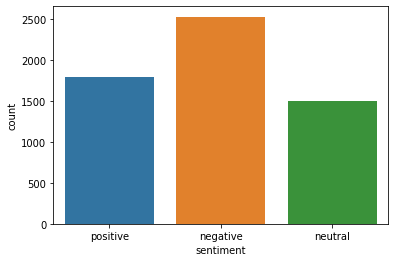

In [8]:
_ = sns.countplot(x='sentiment', data=df)

# Calling methods for preprocessing

In [21]:
df['tweet']

1        أهنئ الدكتور أحمد جمال الدين، القيادي بحزب مصر...
2        البرادعي يستقوى بامريكا مرةاخرى و يرسل عصام ال...
4        الوالدة لو اقولها بخاطري حشيشة تضحك بس من اقول...
5        #انتخبوا_العرص #انتخبوا_البرص #مرسى_رئيسى #اين...
6        امير عيد هو اللي فعلا يتقال عليه ستريكر صريح #...
                               ...                        
14283    لا ولاقى واحد بيقول قطر بتمول الوايت نايتس !!!...
14284    اقسم بالله شركه اورانج دى عليها كرم وذوق عدى ا...
14285    اعلان فودافون عمرو دياب واعلان اورانج  واعلان ...
14286                   اعلان فودافون يستاهل يطلع تريند ♥️
14287    منزلة ستوري واتساب ع حوار إنك تفتح نت من فوداف...
Name: tweet, Length: 7502, dtype: object

In [9]:
preProcess(df)

# Vectorizers

In [23]:
count_vec = CountVectorizer(ngram_range=(1,1))

In [95]:
tfidf_vec = TfidfVectorizer()

# Splitting data

In [96]:
X_train_tfidf,X_test_tfidf,Y_train_tfidf,Y_test_tfidf = train_test_split(tfidf_vec.fit_transform(df['tweet']), df['sentiment'], test_size=0.25, random_state=1)

In [26]:
X_train_count,X_test_count,Y_train_count,Y_test_count = train_test_split(count_vec.fit_transform(df['tweet']), df['sentiment'], test_size=0.25, random_state=1)

In [27]:
X_train ,X_test ,Y_train ,Y_test  = train_test_split(df['tweet'], df['sentiment'], test_size=0.25, random_state=1)

In [28]:
Y_test_tfidf.head()

10140    positive
10364    negative
2016     negative
623      negative
9780     positive
Name: sentiment, dtype: object

In [29]:
le = LabelEncoder()
Y_test_tfidf = le.fit_transform(Y_test_tfidf)
Y_test_count = le.fit_transform(Y_test_count)
Y_test = le.fit_transform(Y_test)
Y_train_tfidf = le.fit_transform(Y_train_tfidf)
Y_train_count = le.fit_transform(Y_train_count)
Y_train = le.fit_transform(Y_train)

# Naive Bayes

In [23]:
cl = MultinomialNB()

## Using Lexicon and Count Vectorization

In [31]:
#calculate the lexicon
tweet_train_lex = []
for tweet in X_train:
    tweet_train_lex.append(calc_lexicon(u"%s" %tweet))

tweet_test_lex = []
for tweet in X_test:
    tweet_test_lex.append(calc_lexicon(u"%s" %tweet))

In [32]:
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
tweet_lex_train_sparse = csr_matrix(tweet_train_lex)
tweet_lex_test_sparse = csr_matrix(tweet_test_lex)
tweet_lex_test_sparse

<1876x2 sparse matrix of type '<class 'numpy.float64'>'
	with 1378 stored elements in Compressed Sparse Row format>

In [33]:
train_feature_matrix = hstack((X_train_count, tweet_lex_train_sparse))
test_feature_matrix = hstack((X_test_count, tweet_lex_test_sparse))
test_feature_matrix

<1876x21018 sparse matrix of type '<class 'numpy.float64'>'
	with 18633 stored elements in Compressed Sparse Row format>

In [34]:
nb_lexicon = cl.fit(train_feature_matrix,Y_train)
predicted = cl.predict(test_feature_matrix)
acc = accuracy_score(Y_test,predicted)
print ('accuracy = '+str(acc*100)+'%')
print (classification_report(Y_test,predicted))

accuracy = 64.87206823027718%
              precision    recall  f1-score   support

           0       0.63      0.65      0.64       620
           1       0.37      0.22      0.27       377
           2       0.72      0.83      0.77       879

    accuracy                           0.65      1876
   macro avg       0.57      0.57      0.56      1876
weighted avg       0.62      0.65      0.63      1876



In [35]:
nb_lex_model_path = 'Models/nb_lexicon_model.sav'
pickle.dump(nb_lexicon, open(nb_lex_model_path,'wb'))

## Using TF-IDF

In [36]:
nb_tfidf = cl.fit(X_train_tfidf, Y_train_tfidf)
p = cl.predict(X_test_tfidf)
acc = accuracy_score(Y_test_tfidf,p)
print ('accuracy = '+str(acc*100)+'%')
print (classification_report(Y_test,p))

accuracy = 62.20682302771855%
              precision    recall  f1-score   support

           0       0.65      0.53      0.59       620
           1       0.33      0.01      0.02       377
           2       0.61      0.95      0.74       879

    accuracy                           0.62      1876
   macro avg       0.53      0.50      0.45      1876
weighted avg       0.57      0.62      0.55      1876



In [37]:
nb_tfidf_model_path = 'Models/nb_tfidf_model.sav'
pickle.dump(nb_tfidf, open(nb_tfidf_model_path,'wb'))

# Lexicon + TF-IDF

In [38]:
train_feature_matrix_tf = hstack((X_train_tfidf, tweet_lex_train_sparse))
test_feature_matrix_tf = hstack((X_test_tfidf, tweet_lex_test_sparse))
test_feature_matrix_tf

<1876x21018 sparse matrix of type '<class 'numpy.float64'>'
	with 18633 stored elements in Compressed Sparse Row format>

In [39]:
nb_lex_tfidf = cl.fit(train_feature_matrix_tf,Y_train)
predicted = cl.predict(test_feature_matrix_tf)
acc = accuracy_score(Y_test,predicted)
print ('accuracy = '+str(acc*100)+'%')
print (classification_report(Y_test,predicted))

accuracy = 62.79317697228145%
              precision    recall  f1-score   support

           0       0.63      0.60      0.61       620
           1       0.20      0.01      0.01       377
           2       0.63      0.91      0.75       879

    accuracy                           0.63      1876
   macro avg       0.49      0.51      0.46      1876
weighted avg       0.54      0.63      0.55      1876



In [40]:
nb_lex_tfidf_model_path = 'Models/nb_lex_tfidf_model.sav'
pickle.dump(nb_lex_tfidf, open(nb_lex_tfidf_model_path,'wb'))

# Logistic Regression TF-IDF

In [41]:
lg =  LogisticRegression(max_iter=1000)

In [42]:
# make param grid
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# create and fit the model
model = GridSearchCV(lg, param_grid, cv=10)

In [43]:
lg_model_path = 'Models/lg_tfidf_model.sav'

In [44]:
model.fit(X_train_tfidf,Y_train_tfidf)
pickle.dump(model, open(lg_model_path,'wb'))

In [45]:
# make prediction and print accuracy
prediction = model.predict(X_test_tfidf)
print(f"Accuracy score is {accuracy_score(Y_test_tfidf, prediction):.2f}")

Accuracy score is 0.67


In [46]:
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.58      0.77      0.66       620
           1       0.55      0.11      0.19       377
           2       0.76      0.84      0.80       879

    accuracy                           0.67      1876
   macro avg       0.63      0.57      0.55      1876
weighted avg       0.66      0.67      0.63      1876



# Logistic Reg using Lexicon + Count Vectorizer

In [47]:
lg_lexicon = model.fit(train_feature_matrix,Y_train)
pickle.dump(model, open(lg_model_path,'wb'))
prediction = model.predict(test_feature_matrix)
print(f"Accuracy score is {accuracy_score(Y_test, prediction):.2f}")
print(classification_report(Y_test, prediction))

Accuracy score is 0.68
              precision    recall  f1-score   support

           0       0.62      0.75      0.68       620
           1       0.51      0.14      0.22       377
           2       0.74      0.86      0.79       879

    accuracy                           0.68      1876
   macro avg       0.62      0.58      0.56      1876
weighted avg       0.65      0.68      0.64      1876



In [48]:
lg_lexicon_model_path = 'Models/lg_lexicon_model.sav'
pickle.dump(lg_lexicon, open(lg_lexicon_model_path,'wb'))

## Using Word Embedding

In [46]:
SVM_SVC = SVC()

In [87]:
padding = 250

In [48]:
embeddings_dict = read_dict("Word Embeddings/dict_2_2_50.txt")

In [88]:
sequencer = Sequencer(df['tweet'], embeddings_dict, padding)

In [89]:
embeddings_matrix = []
for tweet in df['tweet']:
    tweet_vec = sequencer.padder(sequencer.text_to_vec(tweet))
    embeddings_matrix.append(tweet_vec)
embeddings_matrix = np.array(embeddings_matrix)

In [90]:
df_embedding = pd.DataFrame(embeddings_matrix)
df_embedding.head()

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,0.008410,-0.015156,-0.015701,-0.002407,0.014450,0.012534,0.013854,0.015760,-0.017170,-0.001400,...,-0.000611,-0.015481,-0.019264,0.000354,0.005236,0.013185,-0.004070,-0.022848,-0.000622,0.030873
1,-0.027249,0.001513,-0.038116,0.023499,-0.004616,-0.049360,0.038407,0.080597,-0.059024,-0.017923,...,0.027704,-0.013298,-0.010220,-0.007417,0.062927,0.030669,-0.004728,-0.028271,0.012517,0.014055
2,-0.033095,0.019470,-0.020363,0.002425,-0.014626,-0.105112,0.103021,0.148458,-0.119840,-0.020810,...,0.040619,-0.050823,-0.011283,0.006291,0.182110,0.043939,0.000477,-0.052363,0.028714,0.061510
3,-0.117823,-0.081739,0.003649,-0.041054,-0.117537,-0.196755,0.068341,0.366526,-0.243532,-0.103234,...,0.070413,-0.035549,0.007903,0.019112,0.231619,0.024672,0.001036,-0.092943,0.060157,0.056982
4,-0.009253,-0.001551,-0.009816,0.008598,-0.017704,-0.019205,0.005579,0.021667,0.003039,0.014501,...,0.024660,-0.003554,0.014872,0.014720,0.060099,0.027731,0.013610,-0.014391,0.017970,0.025638


In [91]:
for i in range(padding):
    df_embedding[i] =( df_embedding[i] - df_embedding[i].mean() ) / df_embedding[i].std()
    # df_embedding[str(i)] = [sequencer.padder(sequencer.text_to_vec(tweet))[i] for tweet in df['tweet']]
    
df_embedding.head()

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,1.010328,-1.056574,0.434269,-0.849692,1.393601,0.966746,-0.718053,-0.778909,0.742930,0.791072,...,-0.640188,0.382029,-0.218101,-0.589637,-0.612417,-0.397366,0.238144,0.310932,-0.636955,-0.265218
1,0.268283,0.273076,-0.114771,-0.006422,0.357030,0.412432,-0.464660,-0.408933,0.437811,0.389011,...,-0.175162,0.417798,0.148517,-0.856288,-0.311498,-0.092525,0.197758,0.234394,-0.345016,-0.466791
2,0.146616,1.705424,0.320072,-0.692385,-0.187225,-0.086872,0.202192,-0.021704,-0.005546,0.318766,...,0.036939,-0.197015,0.105426,-0.385923,0.310165,0.138850,0.517012,-0.105630,0.014879,0.101997
3,-1.616509,-6.367611,0.908266,-2.107712,-5.782229,-0.907612,-0.155726,1.222654,-0.907284,-1.686823,...,0.526267,0.053228,0.883172,0.053957,0.568404,-0.197085,0.551304,-0.678354,0.713517,0.047718
4,0.642772,0.028654,0.578435,-0.491467,-0.354530,0.682498,-0.803454,-0.745204,0.890257,1.177978,...,-0.225159,0.577440,1.165652,-0.096730,-0.326250,-0.143755,1.322511,0.430292,-0.223845,-0.327958


In [92]:
X_train_em ,X_test_em ,Y_train_em ,Y_test_em  = train_test_split(df_embedding, df['sentiment'], test_size=0.25, random_state=1)

In [93]:
svc_embedding = SVM_SVC.fit(X_train_em,Y_train_em)
predicted = svc_embedding.predict(X_test_em)
acc = accuracy_score(Y_test_em,predicted)
print ('accuracy = '+str(acc*100)+'%')
print (classification_report(Y_test_em,predicted))

accuracy = 46.735395189003434%
              precision    recall  f1-score   support

    negative       0.48      0.79      0.60       639
     neutral       0.80      0.01      0.02       371
    positive       0.44      0.38      0.41       445

    accuracy                           0.47      1455
   macro avg       0.57      0.39      0.34      1455
weighted avg       0.55      0.47      0.39      1455



In [98]:
svc_tfidf = SVM_SVC.fit(X_train_tfidf,Y_train_tfidf)
predicted = svc_tfidf.predict(X_test_tfidf)
acc = accuracy_score(Y_test_em,predicted)
print ('accuracy = '+str(acc*100)+'%')
print (classification_report(Y_test_em,predicted))

accuracy = 55.53264604810997%
              precision    recall  f1-score   support

    negative       0.51      0.95      0.66       639
     neutral       0.72      0.05      0.09       371
    positive       0.74      0.42      0.53       445

    accuracy                           0.56      1455
   macro avg       0.66      0.47      0.43      1455
weighted avg       0.64      0.56      0.48      1455

